In [3]:
import requests
import pandas as pd

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

params = {
    "format": "geojson",
    "starttime": "2013-01-01",
    "endtime": "2024-10-28",
    "minmagnitude": 0,
    "maxmagnitude": 10,
    "minlatitude": 24.0,
    "maxlatitude": 45.5,
    "minlongitude": 122.0,
    "maxlongitude": 153.0
}


response = requests.get(url, params=params)

if response.status_code == 200:

    data = response.json()

    earthquake = pd.json_normalize(data['features'])


    earthquake = earthquake[['properties.time', 'properties.place', 'properties.mag', 'geometry.coordinates']]
    earthquake['properties.time'] = pd.to_datetime(earthquake['properties.time'], unit='ms')


    # earthquake.to_csv("earthquake.csv", index=False)

else:
    print("요청 실패, 상태 코드:", response.status_code)
    print("오류 메시지:", response.text)


In [4]:
earthquake_data = earthquake.copy()

In [5]:
len(earthquake_data)

13675

In [6]:
earthquake_data.columns = ['date', 'location', 'magnitude', 'coordinates']
# earthquake_data = earthquake_data.set_index('date')

In [7]:
earthquake_data = earthquake_data.loc[earthquake_data['location'] == 'Izu Islands, Japan region', ['date','magnitude', 'location']]

In [8]:
earthquake_data['date'] = earthquake_data['date'].astype(str)
earthquake_data['date'] = earthquake_data['date'].apply(lambda x: x[:11])

In [9]:
earthquake_data['date'] = pd.to_datetime(earthquake_data['date'])
earthquake_data['date'] = earthquake_data['date'].dt.floor('D')

In [10]:
earthquake_data = earthquake_data.groupby('date')['magnitude'].mean().reset_index()
earthquake_data = earthquake_data.set_index('date')

In [11]:
full_range = pd.date_range(start=earthquake_data.index.min(),
                           end=earthquake_data.index.max(), freq='D')

# 전체 날짜 범위를 인덱스로 하는 새로운 데이터프레임 생성
full_data = pd.DataFrame(index=full_range)

# 기존 데이터와 병합하여 빠진 날짜는 NaN으로 채워짐
earthquake_data = full_data.join(earthquake_data)

In [12]:
earthquake_data['magnitude'] = earthquake_data['magnitude'].fillna(0)
# earthquake_data['magnitude'] = earthquake_data['magnitude'].interpolate(method='linear')

In [13]:
earthquake_data = earthquake_data.reset_index()
earthquake_data.rename(columns={'index': 'date'}, inplace=True)

# 해수면 온도데이터 전처리

In [14]:
sst_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/프로젝트2/japan_sst_daily_averages_2017_to_202004_combined.csv")

In [15]:
sst_df.describe()

,sst,anom,err,ice,date
count,2658.000000,2658.000000,2658.000000,0.0,2.658000e+03
mean,21.642679,0.515509,0.218761,NaN,2.016220e+07
std,3.522644,1.089678,0.089507,NaN,2.105017e+04
min,14.715625,-2.675625,0.132500,NaN,2.013010e+07
25%,18.795625,-0.262266,0.155313,NaN,2.014103e+07
50%,21.310311,0.649687,0.186875,NaN,2.016082e+07
75%,24.527656,1.321094,0.246172,NaN,2.018062e+07
max,28.709063,3.142500,0.526562,NaN,2.020041e+07


In [16]:
sst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sst     2658 non-null   float64
 1   anom    2658 non-null   float64
 2   err     2658 non-null   float64
 3   ice     0 non-null      float64
 4   date    2658 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 104.0 KB


In [17]:
sst_df.head()

,sst,anom,err,ice,date
0,17.424686,-1.231562,0.159375,NaN,20130101
1,17.555313,-1.039375,0.161875,NaN,20130102
2,17.467812,-1.067812,0.209375,NaN,20130103
3,17.290314,-1.184687,0.166250,NaN,20130104
4,17.278749,-1.135312,0.180625,NaN,20130105


In [18]:
sst_df['date'] = pd.to_datetime(sst_df['date'], format='%Y%m%d')

In [19]:
sst_df = sst_df.set_index('date')

In [20]:
sst_df = sst_df.drop('ice', axis=1)

In [21]:
merged_df = pd.merge(earthquake_data, sst_df, on='date', how='outer')

In [22]:
merged_df

,date,magnitude,sst,anom,err
0,2013-01-01,NaN,17.424686,-1.231562,0.159375
1,2013-01-02,4.6,17.555313,-1.039375,0.161875
2,2013-01-03,0.0,17.467812,-1.067812,0.209375
3,2013-01-04,0.0,17.290314,-1.184687,0.166250
4,2013-01-05,0.0,17.278749,-1.135312,0.180625
...,...,...,...,...,...
4311,2024-10-21,0.0,NaN,NaN,NaN
4312,2024-10-22,0.0,NaN,NaN,NaN
4313,2024-10-23,4.7,NaN,NaN,NaN
4314,2024-10-24,0.0,NaN,NaN,NaN


In [23]:
merged_df.corr()

,date,magnitude,sst,anom,err
date,1.000000,0.059837,0.145245,0.458799,0.032349
magnitude,0.059837,1.000000,-0.004152,-0.033203,0.036588
sst,0.145245,-0.004152,1.000000,0.303161,0.023022
anom,0.458799,-0.033203,0.303161,1.000000,-0.080983
err,0.032349,0.036588,0.023022,-0.080983,1.000000


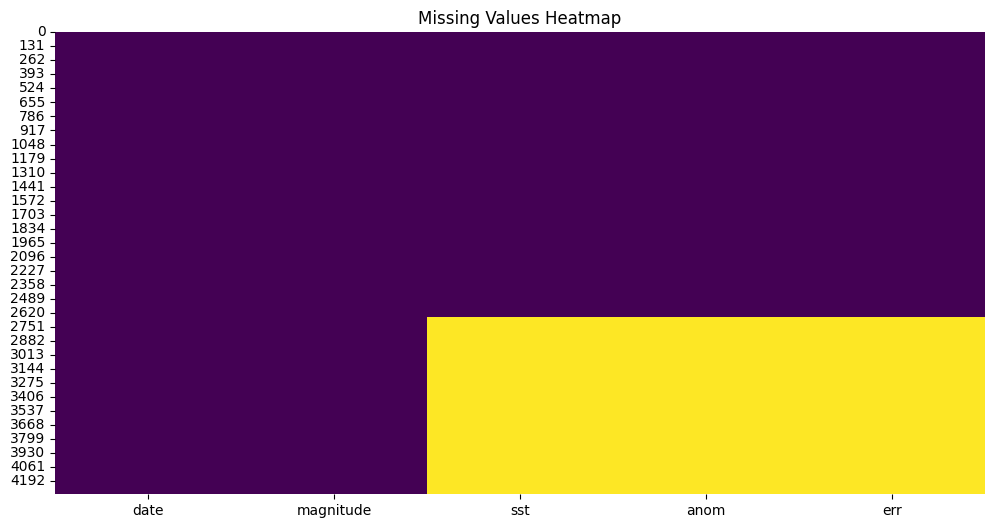

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# NaN 값 확인을 위한 히트맵 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(merged_df.isna(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [25]:
merged_df['magnitude'] = merged_df['magnitude'].fillna(0)

In [26]:
merged_df = merged_df.dropna(axis=0)

In [27]:
merged_df

,date,magnitude,sst,anom,err
0,2013-01-01,0.0,17.424686,-1.231562,0.159375
1,2013-01-02,4.6,17.555313,-1.039375,0.161875
2,2013-01-03,0.0,17.467812,-1.067812,0.209375
3,2013-01-04,0.0,17.290314,-1.184687,0.166250
4,2013-01-05,0.0,17.278749,-1.135312,0.180625
...,...,...,...,...,...
2655,2020-04-09,4.1,19.014687,1.206250,0.182812
2656,2020-04-10,0.0,19.377499,1.530313,0.151875
2657,2020-04-11,0.0,19.364374,1.477812,0.208750
2658,2020-04-12,0.0,19.754375,1.831875,0.257812


In [28]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df[['magnitude', 'sst', 'anom', 'err']])



In [29]:
def load_data(data, seq_len):
    X = []
    y = []

    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i, 0])
        y.append(data[i, 0])
    return X, y

In [30]:
seq_len = 30
X, y = load_data(scaled_data, seq_len)

In [31]:
num = int(len(scaled_data) * 0.8)
num

2126

In [32]:
X_train = X[:num]
y_train = y[:num]
X_test = X[num:]
y_test = y[num:]

import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (len(X_train), seq_len, 1))
X_test = np.reshape(X_test, (len(X_test), seq_len, 1))

In [33]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2126, 30, 1)
y_train.shape =  (2126,)
x_test.shape =  (502, 30, 1)
y_test.shape =  (502,)


In [34]:
import tensorflow as tf
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, Bidirectional
from keras.models import Sequential

model_lstm = Sequential()

model_lstm.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(64, activation='tanh', return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(24, activation='tanh'))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24)                  │           8,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,773 (487.39 KB)

 Trainable params: 124,773 (487.39 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 모델 컴파일
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# 조기 종료 콜백 설정
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# 모델 훈련
history = model_lstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # 훈련 데이터의 20%를 검증용으로 사용
    # callbacks=[early_stopping],
    verbose=1
)



Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0877 - mean_absolute_error: 0.2427 - val_loss: 0.0812 - val_mean_absolute_error: 0.2408
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0844 - mean_absolute_error: 0.2332 - val_loss: 0.0813 - val_mean_absolute_error: 0.2156
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0826 - mean_absolute_error: 0.2326 - val_loss: 0.0823 - val_mean_absolute_error: 0.2521
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0846 - mean_absolute_error: 0.2465 - val_loss: 0.0808 - val_mean_absolute_error: 0.2317
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0837 - mean_absolute_error: 0.2369 - val_loss: 0.0812 - val_mean_absolute_error: 0.2166
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0798 - mean_absolute_error: 0.2252 - val_loss: 0.0820 - val_mean_absolute_error: 0.2095
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0825 - mean_absolute_error: 0.2257 - val_

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lstmPredict = model_lstm.predict(X_test)
lstmScore = r2_score(y_test, lstmPredict)
print("R2 Score : ", lstmScore)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, lstmPredict)
print("MAE: ", mae)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, lstmPredict)
print("MSE: ", mse)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
R2 Score :  -0.009927171661340939
MAE:  0.2505643315799744
MSE:  0.08630629550296402


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# 훈련 손실 및 검증 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
